In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from mnist import MNIST
from sklearn import manifold
import numpy as np
from time import time
from matplotlib import offsetbox

In [2]:
mndata = MNIST('Data/mnist')
train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

In [3]:
X_tr = np.array(train_images)
y_tr = np.array(train_labels)
X_te = np.array(test_images)
y_te = np.array(test_labels)

In [4]:
img_tr = X_tr.reshape([-1, 1,28,28])
img_te = X_te.reshape([-1, 1,28,28])

In [5]:
X_tr.shape

(60000, 784)

In [6]:
# X_tr = X_tr.reshape([-1, 28, 28])
img_tr.shape

(60000, 1, 28, 28)

In [7]:
# Scale and visualize the embedding vectors
def plot_embedding(X, y, img, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-2:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(img[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

Computing t-SNE embedding
2.9979777336120605


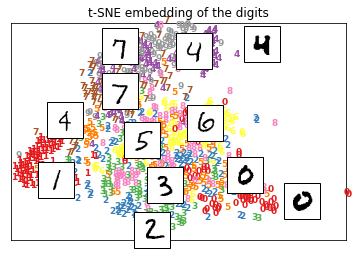

In [113]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)

s = time()
X_tsne = tsne.fit_transform(X_te[:1000])
print(time() - s)

plot_embedding(X_tsne, y_te[:1000], img_te.reshape([-1, 28,28,1]),
               "t-SNE embedding of the digits")

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        #Encoder
        self.conv1 = nn.Conv2d( 1,  8, 3, stride=2,padding=1) #28x28x1 -> 14x14x8
        self.conv2 = nn.Conv2d( 8, 16, 3, stride=2,padding=1) #14x14x8 -> 7x7x16
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2) #7x7x16 -> 3x3x32
        self.conv4 = nn.Conv2d(32, 32, 3, stride=1) #3x3x32 -> 1x1x32
        self.fc1   = nn.Linear(32, 10)
        
        #Decoder
        self.t_fc1   = nn.Linear(10, 32) # [32]
        self.t_conv1 = nn.ConvTranspose2d(32, 32, 3, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 16, 3, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16,  8, 3, stride=2, padding=1)
        self.t_conv4 = nn.ConvTranspose2d(8,   1, 3, stride=2, output_padding=1)
    
    def encoder(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))        
        x = F.relu(self.conv3(x))        
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        return x
    
    def decoder(self, x):
        x = F.relu(self.t_fc1(x)) # 10 -> 32
        x = x.reshape([-1,32,1,1])
        x = F.relu(self.t_conv1(x)) # [m, 1,1,32] -> [m, 3,3,32]
        x = F.relu(self.t_conv2(x)) # [m, 3,3,32] -> [m, 7,7,16]
        x = F.relu(self.t_conv3(x)) # [m, 7,7,16] -> 
        x = F.relu(self.t_conv4(x))
        return x                    #[m, 1, 28, 28]
    
    def forward(self, x):
        latent_vector    = self.encoder(x)
        predicted_output = self.decoder(latent_vector)
        return predicted_output
        

In [11]:
model = AutoEncoder()

In [87]:
r = torch.randn(5, 1, 28, 28)
rout = model.encoder(r)
rout.shape

torch.Size([5, 10])

In [88]:
model.decoder(rout).shape

torch.Size([5, 1, 28, 28])

In [14]:
model.forward(r).shape

torch.Size([5, 1, 28, 28])

In [15]:
model.forward(torch.tensor(img_te, dtype=torch.float)).shape

torch.Size([10000, 1, 28, 28])

In [16]:
# temp = torch.tensor(img_te, dtype=torch.float)
# temp[0]/255

In [17]:
img_tr[:100].shape

(100, 1, 28, 28)

In [18]:
img_tr_tensor = torch.tensor(img_tr[:1000])/255.0 #converting from 0-255 to 0.0-1.0
y_tr_tensor   = torch.tensor(y_tr[:1000])
img_te_tensor = torch.tensor(img_te)/255.0 #converting from 0-255 to 0.0-1.0
y_te_tensor   = torch.tensor(y_te)

train_dataset = torch.utils.data.TensorDataset(img_tr_tensor, y_tr_tensor)
test_dataset  = torch.utils.data.TensorDataset(img_te_tensor, y_te_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=0)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=1, num_workers=0)

In [19]:
loss_fxn  = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

In [66]:
n_epochs = 100

for epoch in range(n_epochs):
    train_loss = 0.0
    for data in train_loader:
        images, _ = data
        outputs = model.forward(images)
        loss = loss_fxn(outputs, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         plt.imshow(images[0].permute(1,2,0))
#         plt.show()
        train_loss+=(loss.item()*images.size(0))
#         print(train_loss)
        
    train_loss = train_loss#/len(train_loader)
    print("Epoch: {} \t Training Loss: {}".format(epoch, train_loss))

Epoch: 0 	 Training Loss: 15.953672800213099
Epoch: 1 	 Training Loss: 15.923928618431091
Epoch: 2 	 Training Loss: 15.917147889733315
Epoch: 3 	 Training Loss: 15.909867778420448
Epoch: 4 	 Training Loss: 15.925805225968361
Epoch: 5 	 Training Loss: 15.950501911342144
Epoch: 6 	 Training Loss: 15.922636099159718
Epoch: 7 	 Training Loss: 15.97611404210329
Epoch: 8 	 Training Loss: 16.00447130203247
Epoch: 9 	 Training Loss: 16.0890652872622
Epoch: 10 	 Training Loss: 16.209284111857414
Epoch: 11 	 Training Loss: 16.228441573679447
Epoch: 12 	 Training Loss: 16.34141205996275
Epoch: 13 	 Training Loss: 16.507047042250633
Epoch: 14 	 Training Loss: 16.722153268754482
Epoch: 15 	 Training Loss: 16.985554836690426
Epoch: 16 	 Training Loss: 17.16188146919012
Epoch: 17 	 Training Loss: 17.185665853321552
Epoch: 18 	 Training Loss: 17.366061687469482
Epoch: 19 	 Training Loss: 17.554074943065643
Epoch: 20 	 Training Loss: 18.05715473741293
Epoch: 21 	 Training Loss: 17.926452912390232
Epoch

(28, 28, 1)


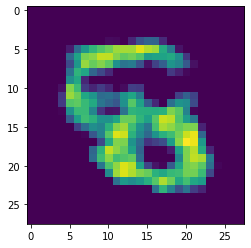

In [112]:
y_pred = model.forward(img_te_tensor[18:19])[0]
y_pred.shape
temp = y_pred.permute(1,2,0).detach().numpy()
print(temp.shape)
# print(y_pred)
# type(y_pred)
plt.imshow(temp)
plt.show()

In [82]:
def display_img(tensor):
    m = tensor.shape[0]
    for i in range(m):
        temp = tensor[i].permute(1,2,0).detach().numpy()
        plt.imshow(temp)
        plt.show()

torch.Size([2, 10])
torch.Size([2, 1, 28, 28])
2


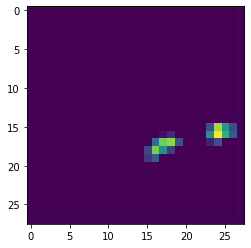

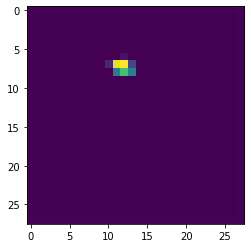

In [111]:
# Generating a random latent vector.
# Generated image in random!!
lat = torch.randn([2, 10])
print(lat.shape)
out = model.decoder(lat)
print(out.shape)
print(out.shape[0])
display_img(out)

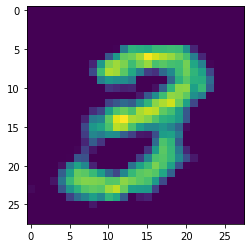

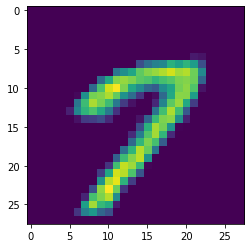

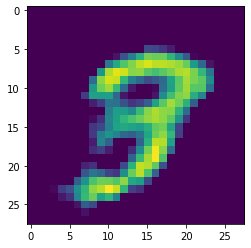

In [127]:
l1 = model.encoder(img_tr_tensor[7:8])
l2 = model.encoder(img_tr_tensor[15:16])
l_avg = (l1+l2)/2

o1 = model.decoder(l1)
o2 = model.decoder(l2)
o3 = model.decoder(l_avg)

display_img(o1)
display_img(o2)
display_img(o3)